## Beginner Project

### Simple sklearn Regression and Classification with the Ames Housing Data. 

---

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pandas_profiling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Secondary import of all sklearn Linear regression & preprocessing modules:
# Add PolynomialFeatures and or MinMaxScaler if required:

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score

In [3]:
# Opened the data description .txt file in another window to read:

## 1. Estimating the value of homes from fixed characteristics.

---

By implementing the following:


1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Goals:**

1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

In [4]:
# Load the data
house = pd.read_csv('./housing.csv')

In [5]:
house.shape

(1460, 81)

In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# A:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [8]:
# Pandas Profile Report:
# This takes an abnormally long amount of time to run & generate (dependent on complexity of dataset):
# May be handy for future datasets

# This Report looks handy & will help, (63MB html file though, CPU & RAM intensive, remove before project submission)
# No need to re-run

# profile = house.profile_report(title='House Pandas Profiling Report')
# profile.to_file(output_file="house_pandas_profiling.html")

## Data Cleaning, EDA & Feature Engineering

### Identifying & Replacing null values:

In [9]:
nulls = house.isnull().sum().to_frame('nulls')

In [10]:
# Manually note down the cols with nulls
# Verify with pandas profiling report

for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


In [11]:
# Inspect each of these columns with nulls:

# If numeric, drop outliers (percentile <0.01 and >0.99)
# then fillna with col mean as more evenly distributed (without outliers)

lower_lf = house['LotFrontage'].quantile(.01)
upper_lf = house['LotFrontage'].quantile(.99)

house['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [12]:
house['LotFrontage'] = house['LotFrontage'].clip(lower=lower_lf, upper=upper_lf)

In [13]:
# then fillna with 0 as this could realistically mean no lot frontage at all per data description

house['LotFrontage'] = house['LotFrontage'].fillna(0)
house['LotFrontage'].isnull().sum()

0

In [14]:
house['LotFrontage'].describe()

count    1460.000000
mean       57.253425
std        33.098729
min         0.000000
25%        42.000000
50%        63.000000
75%        79.000000
max       141.000000
Name: LotFrontage, dtype: float64

In [15]:
# For object/str cols: 

# This col where NaN should be 'No Alley' str - fillna with that

house['Alley'].describe()

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

In [16]:
house['Alley'].fillna('No Alley', inplace=True)

In [17]:
house['Alley'].unique()

array(['No Alley', 'Grvl', 'Pave'], dtype=object)

In [18]:
# Note that 'None' not the same as None (No Veneer)

# Masonry Veneer Type:

# I suppose I can replace nan with 'None' as it can substitute as the default?

house['MasVnrType'].fillna('None', inplace=True)
house['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

In [19]:
# Drop outliers

# replace 8 missing values with filtered median (as a lot of 0s in this column)

lower_mva = house['MasVnrArea'].quantile(.01)
upper_mva = house['MasVnrArea'].quantile(.99)

house['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [20]:
house['MasVnrArea'] = house['MasVnrArea'].clip(lower=lower_mva, upper=upper_mva)

In [21]:
# fillna with median

house['MasVnrArea'] = house['MasVnrArea'].fillna(house['MasVnrArea'].median())
house['MasVnrArea'].isnull().sum()

0

In [22]:
# check
house['MasVnrArea'].describe()

count    1460.000000
mean      100.620411
std       167.751882
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max       791.920000
Name: MasVnrArea, dtype: float64

In [23]:
# Check data dictionary for this and relevant categorical cols below:

# The below 5 cols have 37-38 missing values so may have some overlap (Basement)

# Basement Quality (height of basement, > height, > quality)

# Ex	Excellent
# Gd	Good
# TA	Typical
# Fa	Fair 
# Po	Poor 
# NA	No Basement (fill na with string)

house['BsmtQual'].fillna('No Basement', inplace=True)
house['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', 'No Basement', 'Fa'], dtype=object)

In [24]:
# BsmtCond: Evaluates the general condition of the basement
# fillna with string ('No Basement')

house['BsmtCond'].fillna('No Basement', inplace=True)
house['BsmtCond'].unique()

array(['TA', 'Gd', 'No Basement', 'Fa', 'Po'], dtype=object)

In [25]:
# BsmtExposure: Refers to walkout or garden level walls
# fillna with string

house['BsmtExposure'].fillna('No Basement', inplace=True)
house['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', 'No Basement'], dtype=object)

In [26]:
# BsmtFinType1: Rating of basement finished area
# fillna with string

house['BsmtFinType1'].fillna('No Basement', inplace=True)
house['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'No Basement', 'LwQ'],
      dtype=object)

In [27]:
# BsmtFinType2: Rating of basement finished area (if multiple types)
# fillna with string

house['BsmtFinType2'].fillna('No Basement', inplace=True)
house['BsmtFinType2'].unique()

array(['Unf', 'BLQ', 'No Basement', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
      dtype=object)

In [28]:
# Electrial: Electrical System
# Only 1 missing here, drop? or replace with mode? (SBrkr)


house['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [29]:
house['Electrical'].describe()

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

In [30]:
# Fill na with 'SBrkr'

house['Electrical'].fillna('SBrkr', inplace=True)
house['Electrical'].isnull().sum()

0

In [31]:
# FireplaceQu: Fireplace quality
# fillna with str ('No Fireplace')

house['FireplaceQu'].fillna('No Fireplace', inplace=True)
house['FireplaceQu'].unique() # 690 missing here

array(['No Fireplace', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [32]:
# Next five cols have 81 missing values - overlap on (Garage)
# GarageType: Garage location
# Fillna with str ('No Garage')

house['GarageType'].fillna('No Garage', inplace=True)
house['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'No Garage', 'Basment',
       '2Types'], dtype=object)

In [33]:
# count & replace nan - 'No Garage'
# convert to str - Years can be str with unique values (exc. No Garage)
# rstrip the dot and 0

house['GarageYrBlt'].fillna('No Garage', inplace=True)
house['GarageYrBlt'].unique()

array([2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993.0, 2004.0, 1973.0,
       1931.0, 1939.0, 1965.0, 2005.0, 1962.0, 2006.0, 1960.0, 1991.0,
       1970.0, 1967.0, 1958.0, 1930.0, 2002.0, 1968.0, 2007.0, 2008.0,
       1957.0, 1920.0, 1966.0, 1959.0, 1995.0, 1954.0, 1953.0,
       'No Garage', 1983.0, 1977.0, 1997.0, 1985.0, 1963.0, 1981.0,
       1964.0, 1999.0, 1935.0, 1990.0, 1945.0, 1987.0, 1989.0, 1915.0,
       1956.0, 1948.0, 1974.0, 2009.0, 1950.0, 1961.0, 1921.0, 1900.0,
       1979.0, 1951.0, 1969.0, 1936.0, 1975.0, 1971.0, 1923.0, 1984.0,
       1926.0, 1955.0, 1986.0, 1988.0, 1916.0, 1932.0, 1972.0, 1918.0,
       1980.0, 1924.0, 1996.0, 1940.0, 1949.0, 1994.0, 1910.0, 1978.0,
       1982.0, 1992.0, 1925.0, 1941.0, 2010.0, 1927.0, 1947.0, 1937.0,
       1942.0, 1938.0, 1952.0, 1928.0, 1922.0, 1934.0, 1906.0, 1914.0,
       1946.0, 1908.0, 1929.0, 1933.0], dtype=object)

In [34]:
house['GarageYrBlt'] = house['GarageYrBlt'].astype(str)
house['GarageYrBlt'] = house['GarageYrBlt'].str.rstrip('0.')
house['GarageYrBlt'].unique()

array(['2003', '1976', '2001', '1998', '2', '1993', '2004', '1973',
       '1931', '1939', '1965', '2005', '1962', '2006', '196', '1991',
       '197', '1967', '1958', '193', '2002', '1968', '2007', '2008',
       '1957', '192', '1966', '1959', '1995', '1954', '1953', 'No Garage',
       '1983', '1977', '1997', '1985', '1963', '1981', '1964', '1999',
       '1935', '199', '1945', '1987', '1989', '1915', '1956', '1948',
       '1974', '2009', '195', '1961', '1921', '19', '1979', '1951',
       '1969', '1936', '1975', '1971', '1923', '1984', '1926', '1955',
       '1986', '1988', '1916', '1932', '1972', '1918', '198', '1924',
       '1996', '194', '1949', '1994', '191', '1978', '1982', '1992',
       '1925', '1941', '201', '1927', '1947', '1937', '1942', '1938',
       '1952', '1928', '1922', '1934', '1906', '1914', '1946', '1908',
       '1929', '1933'], dtype=object)

In [35]:
house['GarageYrBlt'].describe()

count          1460
unique           98
top       No Garage
freq             81
Name: GarageYrBlt, dtype: object

In [36]:
# GarageFinish: Interior finish of the garage
# Fillna with str ('No Garage')

house['GarageFinish'].fillna('No Garage', inplace=True)
house['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', 'No Garage'], dtype=object)

In [37]:
# GarageQual: Garage quality
# Fillna with str ('No Garage')

house['GarageQual'].fillna('No Garage', inplace=True)
house['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', 'No Garage', 'Ex', 'Po'], dtype=object)

In [38]:
# GarageCond: Garage condition
# Fillna with str ('No Garage')

house['GarageCond'].fillna('No Garage', inplace=True)
house['GarageCond'].unique()

array(['TA', 'Fa', 'No Garage', 'Gd', 'Po', 'Ex'], dtype=object)

In [39]:
# The below 3 cols have a significant amount of nulls (>1000):
# PoolQC: Pool quality
# Fillna with str ('No Pool')

house['PoolQC'].fillna('No Pool', inplace=True)
house['PoolQC'].unique()

array(['No Pool', 'Ex', 'Fa', 'Gd'], dtype=object)

In [40]:
# Fence: Fence quality
# fillna with str ('No Fence')

house['Fence'].fillna('No Fence', inplace=True)
house['Fence'].unique()

array(['No Fence', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [41]:
# MiscFeature: Miscellaneous feature not covered in other categories
# fillna with str ('No Misc Features')

house['MiscFeature'].fillna('No Misc Features', inplace=True)
house['MiscFeature'].unique()

array(['No Misc Features', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [42]:
# This one has outliers, drop them:

lower_mv = house['MiscVal'].quantile(.01)
upper_mv = house['MiscVal'].quantile(.99)

house['MiscVal'].describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

In [43]:
house['MiscVal'] = house['MiscVal'].clip(lower=lower_mv, upper=upper_mv)

In [44]:
house['MiscVal'].describe()

count    1460.000000
mean       19.482192
std       104.884363
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       700.000000
Name: MiscVal, dtype: float64

In [45]:
# Making sure this is an object for train-test split later:

house['YrSold'] = house['YrSold'].astype(str)

In [46]:
house['YrSold'].describe()

count     1460
unique       5
top       2009
freq       338
Name: YrSold, dtype: object

In [47]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- No more nulls
- No more outliers for numeric columns
- Correct column labels for categorical columns

### Further Cleaning & EDA/Feature Engineering of chosen predictor variables (dummify categorical variables)

In [48]:
# Filtered to residential houses only:


def filter_category_with_list(df, category, category_value_list):
    df_filter = df.loc[df[category].isin(category_value_list)]
    return df_filter

In [49]:
# MSZoning: Identifies the general zoning classification of the sale.

house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [50]:
# Data Description indicates that these are residential:

house_res = filter_category_with_list(house, 'MSZoning', ['RH','RL','RP','RM'])
print(house_res['MSZoning'].value_counts())

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64


In [51]:
# Choose my predictor variables (don't fit yet):
# Fixed features only to clean and dummify if categorical

# Once cleaned, save these x cols and y as a copy from house_res df

# examples:

# The neighborhood
# Square feet
# Bedrooms, bathrooms
# Basement and garage space (all cols related to this)

predictors_1 = ['LotFrontage', 'LotArea', 'Street',
                'Alley', 'LotShape', 'LandContour',
                'LotConfig', 'LandSlope', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType',
                'YearBuilt', 'BsmtQual', 'BsmtExposure',
                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                'BsmtHalfBath', 'FullBath', 'HalfBath',
                'TotRmsAbvGrd','Fireplaces', 'GarageType', 'GarageYrBlt',
                'GarageCars', 'GarageArea', 'PavedDrive',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                '3SsnPorch', 'ScreenPorch', 'PoolArea',
                'MiscFeature', 'MiscVal', 'SaleType']


                
Pre_X = house_res[predictors_1]
Pre_X.head()


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,SaleType
0,65.0,8450,Pave,No Alley,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,Y,0,61,0,0,0,0,No Misc Features,0,WD
1,80.0,9600,Pave,No Alley,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,Y,298,0,0,0,0,0,No Misc Features,0,WD
2,68.0,11250,Pave,No Alley,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,Y,0,42,0,0,0,0,No Misc Features,0,WD
3,60.0,9550,Pave,No Alley,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,Y,0,35,272,0,0,0,No Misc Features,0,WD
4,84.0,14260,Pave,No Alley,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,Y,192,84,0,0,0,0,No Misc Features,0,WD


In [52]:
# Dummify, check if numerical cols included (should be included automatically)


categorical_cols = Pre_X.loc[:, Pre_X.dtypes == np.object]
categorical = list(categorical_cols.columns)

Pre_X_cat = pd.get_dummies(Pre_X, columns=categorical, drop_first=True)
Pre_X_cat.head(2)

,LotFrontage,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,65.0,8450,2003,856,856,854,0,1710,1,0,...,0,0,0,0,0,0,0,0,0,1
1,80.0,9600,1976,1262,1262,0,0,1262,0,1,...,0,0,0,0,0,0,0,0,0,1


## Model 1 - On Fixed Features Only - Linear

A general approach you can use for modeling questions would look like this:

1. Cleaning, descriptive stats, correlation heatmap, plots & visualizations. Find baseline score.

1. Set up predictor matrix (X) and target array (y).  Dummify if necessary.

1. Train/test split and StandardScaler( ).

1. Use cross-validation to optimise the hyperparameters for your model. You might try different types of models at this stage as well, and you might use GridSearchCV (or any of the other CVs like RidgeCV, LassoCV, or ElasticNetCV).

1. Once you're happy with your hyperparameters, fit your model on your whole training data and test it on your whole testing data.

1. Then you might want to:
    - Evaluate the performance of the model (R2 score, accuracy, confusion matrix (for classifiers), etc)
    - Find the actual predictions that your model is providing and store them in a dataframe
    - Plot your predictions against your actual target variable to visualize how well your model performed
    - Investigate feature importance with .coef_ if you have a parametric model

In [53]:
# Identify Predictors (X) and Target variable (Y):


X = Pre_X_cat.copy()



y = house_res['SalePrice'].copy()
y.describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [54]:
X.head()

,LotFrontage,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,65.0,8450,2003,856,856,854,0,1710,1,0,...,0,0,0,0,0,0,0,0,0,1
1,80.0,9600,1976,1262,1262,0,0,1262,0,1,...,0,0,0,0,0,0,0,0,0,1
2,68.0,11250,2001,920,920,866,0,1786,1,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,9550,1915,756,961,756,0,1717,1,0,...,0,0,0,0,0,0,0,0,0,1
4,84.0,14260,2000,1145,1145,1053,0,2198,1,0,...,0,0,0,0,0,0,0,0,0,1


In [55]:
baseline = y.mean()
baseline

180136.283032491

In [56]:
# 'YrSold' on how to segment data:

# 'test' size of 11.8%, 5 'chunks' total
# Use a variant of this as a filter for your X predictor variables:

house_res['YrSold'].value_counts(normalize=True)

2009    0.231769
2007    0.225993
2006    0.215884
2008    0.207942
2010    0.118412
Name: YrSold, dtype: float64

In [57]:
house_res['YrSold'].describe()

count     1385
unique       5
top       2009
freq       321
Name: YrSold, dtype: object

In [58]:
# Set x test = 2010, x train for data pre 2010

X_train = X[house_res['YrSold'].isin(['2006', '2007', '2008', '2009'])]
X_test = X[house_res['YrSold'] == '2010']

y_train = y[house_res['YrSold'].isin(['2006', '2007', '2008', '2009'])]
y_test = y[house_res['YrSold'] == '2010']

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1221, 205), (164, 205), (1221,), (164,))

In [60]:
# Baseline

y_train.mean()

180447.2792792793

In [61]:
# Baseline test

y_test.mean()

177820.8780487805

In [62]:
# repeat function basically repeats the mean for the length of col y:

r2_score(y_train, np.repeat(np.mean(y_train), len(y_train))) # output of 0

0.0

In [63]:
r2_score(y_test, np.repeat(np.mean(y_test), len(y_test))) # output of 0

0.0

In [64]:
# Standardize your X_train, X_test

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [65]:
# Score on train, default 5-fold cvs & cv mean, test on the standard model:

# create a linear regression model instance, fitting only train sets
model = LinearRegression()
model.fit(X_train, y_train)

# Add KFold - re use as new cell for model tuning below if needed
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate the data on the whole training set
print("Training Score:", model.score(X_train, y_train))


# evaluate the data on the test set

print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [-1.04690457e+19 -3.92424246e+11 -1.70749770e+24 -9.55435121e+22
 -1.55775907e+24]
Mean cross-validated training score: -6.721621495803725e+23
Training Score: 0.8684127376458746
Test Score: -0.582119196983006


In [66]:
# The above is a pathetic model, cv scores converging around 0, and a horrendus test score.

In [67]:
# Further checks on test score:

def r2(y, pred):
    Nr = np.sum(np.square(y - pred))
    Dr = np.sum(np.square(y - np.mean(y)))
    R_sq = 1 - (Nr / Dr)
    return R_sq

In [68]:
pred = model.predict(X_test)

In [69]:
r2(y_test, pred)

-0.582119196983006

### Model Tuning/Regularization

In [70]:
# Importing model_fitter function from lesson:

# model is a LinReg() object and should already be instantiated:

def model_fitter(model, X_train, y_train, X_test, y_test, cv=5): # 5-fold cv the default, followed by 10
    
    model.fit(X_train, y_train)
    
    # Add KFold
    
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    cv_score = cross_val_score(model, X_train, y_train, cv=kf)
    cv_score_m = np.mean(cv_score)
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return cv_score, cv_score_m, training_score, test_score # outputs in this order

### L2 Ridge Methods

In [71]:
# L2 Ridge default - Order of outputs: cv scores, cv mean, train, test

modelL2 = Ridge(alpha=1) # choose an alpha (lambda in textbooks) level:
model_fitter(modelL2, X_train, y_train, X_test, y_test)

(array([0.77385688, 0.63493215, 0.73297443, 0.87581544, 0.80343766]),
 0.764203313028658,
 0.8684014881510356,
 0.8712494263276513)

In [72]:
# L2 RidgeCV - train & get alpha

modelL2CV = RidgeCV(alphas=np.logspace(-5, 5, 1000), cv=kf)
modelL2CV.fit(X_train, y_train)

L2CV_alpha = modelL2CV.alpha_
print(L2CV_alpha)

405.1423171114647


In [73]:
# L2 Ridge with best alpha - cv, cv mean, train, test

# Funnily enough this is worse than the default Ridge model

modelR = Ridge(alpha=L2CV_alpha) # using new alpha
model_fitter(modelR, X_train, y_train, X_test, y_test)

(array([0.82437401, 0.66216465, 0.76028781, 0.90375594, 0.83045967]),
 0.7962084159336345,
 0.8490417265540662,
 0.8656233487755631)

### L1 Lasso Methods

In [74]:
# L1 Lasso default - cv, cv mean, train, test

# Convergence Warnings are very annoying

modelL1 = Lasso(alpha=0.1, max_iter=10000) 
model_fitter(modelL1, X_train, y_train, X_test, y_test)

/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954319106.9890137, tolerance: 776125422.6991765
  model = cd_fast.enet_coordinate_descent(
/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1946188305.7927246, tolerance: 616703133.5502684
  model = cd_fast.enet_coordinate_descent(
/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 752885173.6972656, tolerance: 584647184.4042102
  model = cd_fast.enet_coordinate_descent(
/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/skle

(array([0.77297207, 0.63445234, 0.73275136, 0.87334676, 0.80345401]),
 0.7633953086143166,
 0.8684180100134756,
 0.8715581629369786)

In [75]:
# L1 LassoCV - train & get alpha

modelL1CV = LassoCV(n_alphas=1000, cv=kf)
modelL1CV.fit(X_train, y_train) # recommended to use n_alphas=100 instead of alphas

L1CV_alpha = modelL1CV.alpha_
print(L1CV_alpha)

995.1644425168807


In [76]:
# L1 Lasso with best alpha - cv, cv mean, train, test

# Doing slightly better than the default L1 model
# And the highest scoring model for the test sets

modelL = Lasso(alpha=L1CV_alpha)
model_fitter(modelL, X_train, y_train, X_test, y_test)

(array([0.82030322, 0.64310491, 0.76097566, 0.90466228, 0.83394252]),
 0.7925977171825268,
 0.8477346976735345,
 0.8741223657362645)

### ElasticNet Methods

In [77]:
# ElasticNet default - cv, cv mean, train, test

modelEL = ElasticNet(alpha=0.1, l1_ratio=0.05) # setting alpha and l1_ratio as balanced as can be
model_fitter(modelEL, X_train, y_train, X_test, y_test)

(array([0.80326616, 0.64875801, 0.75156976, 0.89466933, 0.82703995]),
 0.7850606413663928,
 0.8623052785749183,
 0.8716100858576615)

In [78]:
# ElasticNetCV - train

# ElasticNet requires more alphas, using n_alphas method instead as recommended by prior lesson/lab

modelELCV = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     n_alphas = 1000, cv=kf)

modelELCV.fit(X_train, y_train)


ELCV_alpha = modelELCV.alpha_
ELCV_l1ratio = modelELCV.l1_ratio_

print(ELCV_alpha) # output of best alpha level
print(ELCV_l1ratio) # and best l1_ratio: - lower = ridge, higher = lasso

57.01818770095699
0.99


In [79]:
# ElasticNet with correct l1_ratio & alpha - cv, cv mean, train, test

# The worst of the three regularization methods if ranking by scores

# however the l1 ratio here is telling me to go with the lasso model, 
# and this lines up with the lasso's highest scores on the test set

modelE = ElasticNet(alpha=ELCV_alpha, l1_ratio=ELCV_l1ratio)
model_fitter(modelE, X_train, y_train, X_test, y_test)

(array([0.82455574, 0.66364971, 0.75899668, 0.90280858, 0.82515835]),
 0.7950338102395696,
 0.8359665299853758,
 0.855655325631397)

### Model chosen?


- For the average cross validated scores and the training scores, it's interesting that the default L2 Ridge model with an alpha of 1 does best of all the above, with a CV mean of 0.796, and a train score of 0.849.

- However, for the test scores, and with looking at the ElasticNet model too, it is the l1 Lasso model that is best equipped as a regularization model, with a relatively high alpha of 995, scoring a CV mean of 0.793, a train score of 0.848, both very close to the L2 model, and a test score of 0.874.

In [80]:
# Going with Lasso model with appropriate alpha/lambda:

print(modelL.score(X_train, y_train))
print(modelL.score(X_test, y_test))

0.8477346976735345
0.8741223657362645


In [81]:
# Checking MAE, MSE & RMSE:

y_pred = modelL.predict(X_test)

In [82]:
from sklearn import metrics


# These errors are quite high, 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 19089.875303369954
Mean Squared Error: 824825232.5681357
Root Mean Squared Error: 28719.770761065203


***Why Lasso?***

- The lasso performs slightly better than the Ridge, but similarly.
- Lasso deals primarily with the feature selection of valuable variables, eliminating ones that are not useful.
- This also takes care of multicollinearity, but in a different way: it will choose the "best" of the correlated variables and zero-out the other redundant ones.
- There may also be useless variables in the data which it is simply getting rid of entirely.

### Model Coefficients

In [83]:
modelL_coefs = pd.DataFrame({'variable': X.columns,
                            'coef': modelL.coef_,
                            'abs_coef': np.abs(modelL.coef_)})

modelL_coefs.sort_values('abs_coef', inplace=True, ascending=False)

modelL_coefs.head(30)

,variable,coef,abs_coef
7,GrLivArea,28366.559099,28366.559099
53,Neighborhood_NridgHt,12546.847321,12546.847321
2,YearBuilt,11264.488254,11264.488254
52,Neighborhood_NoRidge,10374.027422,10374.027422
84,BsmtQual_TA,-10081.743328,10081.743328
82,BsmtQual_Gd,-9720.065117,9720.065117
14,GarageCars,9543.086402,9543.086402
59,Neighborhood_StoneBr,7840.364694,7840.364694
85,BsmtExposure_Gd,6053.080179,6053.080179
3,TotalBsmtSF,5703.202530,5703.202530


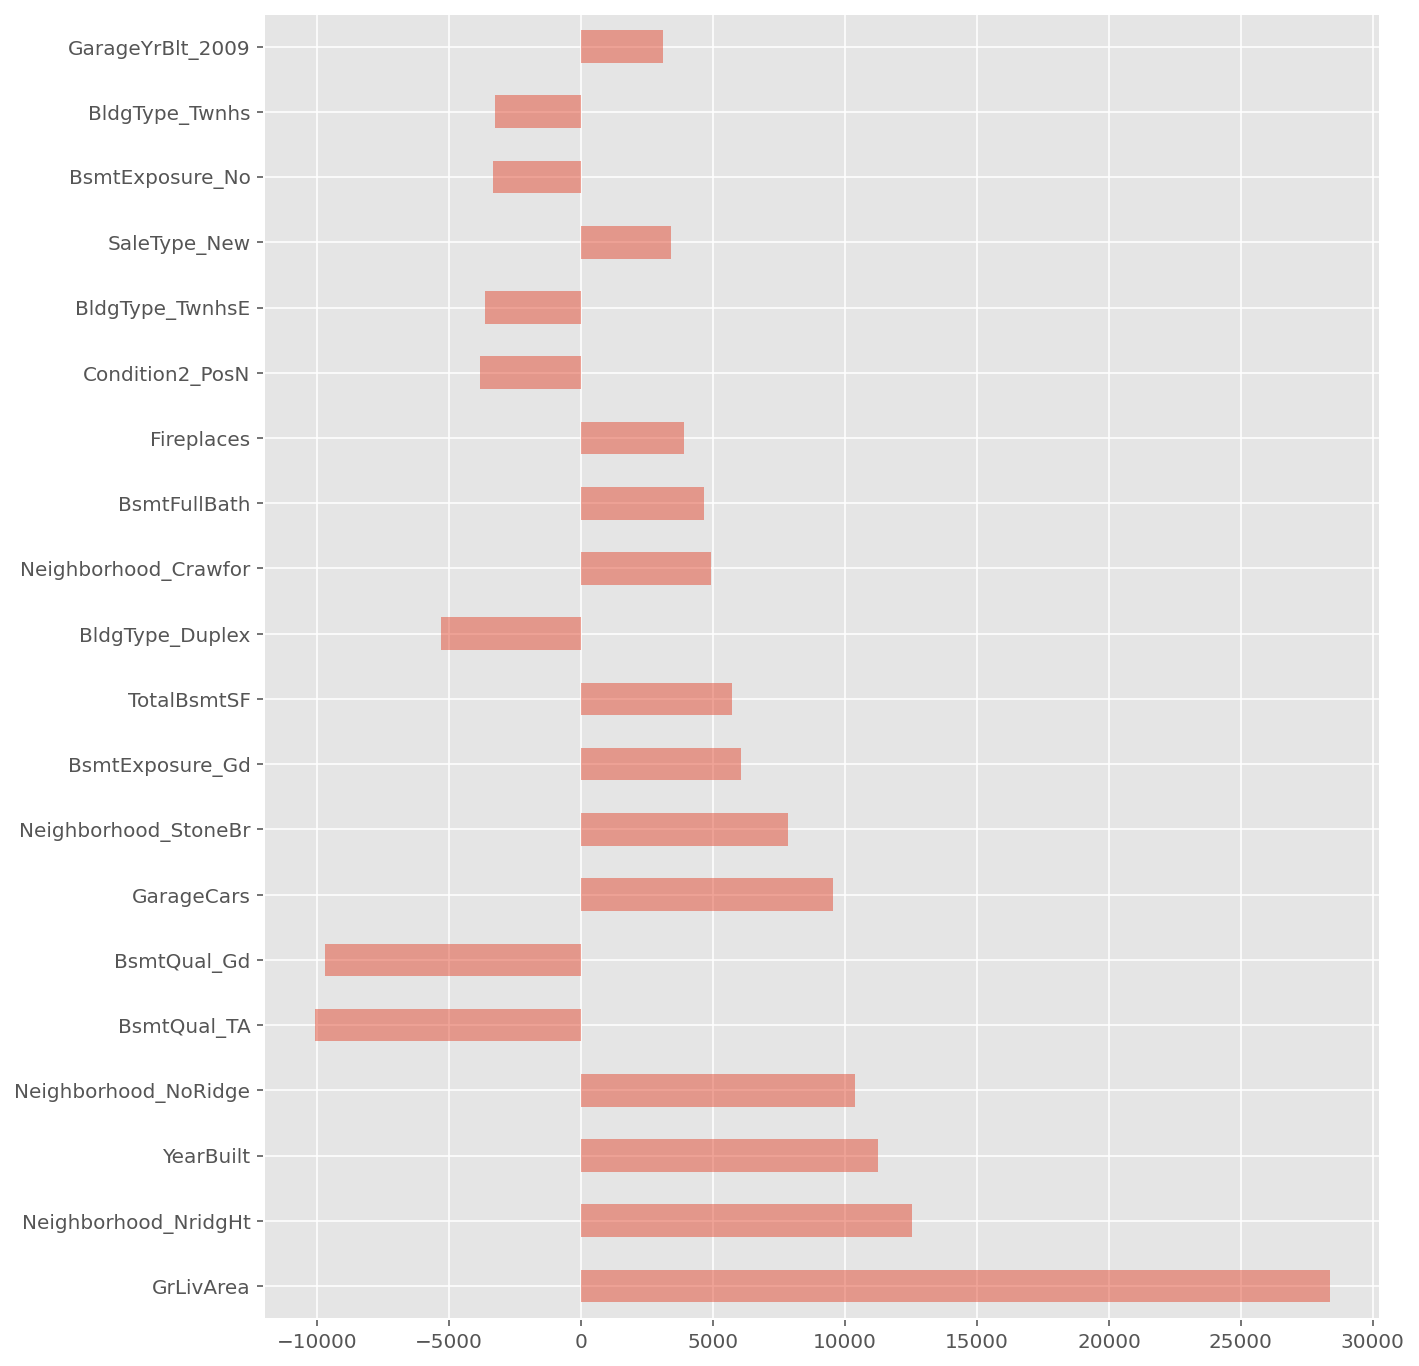

In [84]:
# Coefs Plotted out:

fig, ax = plt.subplots(figsize=(10, 12))
modelL_coefs.coef[:20].plot(kind='barh', ax=ax, alpha=0.5)
ax.set_yticklabels(modelL_coefs.variable[:20].values)
plt.show()

***Answer:***

- Looks like the best predictors of house prices here are:
- GrLivArea: Above grade (ground) living area square feet - this the best predictor by some margin, makes sense as it's the measured 'habitable' or tangible square feet measurement.
- Neighborhood of NridgHt Northridge Heights, and Northridge - these are found to be the preferred neighborhoods in the city.
- YearBuilt - Newer houses would likely be pricier but easier to maintain.

- Furthermore Basement Quality is an interesting one, Good & Typical (2/6 & 3/6) in rankings are considered to have the highest inverse correlation to price - I suppose you either want the best basement or none at all.


## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Getting the model epsilion (residuals or error terms)

In [85]:
# getting the error terms from the train & test sets:

predictions_train = modelL.predict(X_train)
predictions_train[:5]

array([194056.95295292, 203364.0262657 , 221698.19373046, 197043.73756016,
       311565.26001194])

In [86]:
y_train[:5]

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [87]:
# residuals = actual - predicted

epsilon_train = y_train - predictions_train
epsilon_train

0       14443.047047
1      -21864.026266
2        1801.806270
3      -57043.737560
4      -61565.260012
            ...     
1451    29394.260471
1452    -5597.825007
1453   -42224.407551
1455   -10316.007137
1459      603.222065
Name: SalePrice, Length: 1221, dtype: float64

In [88]:
predictions_test = modelL.predict(X_test)
predictions_test[:5]

array([148582.34654537, 150452.46225998, 129631.68742736, 316919.80956804,
       177219.26856096])

In [89]:
y_test[:5]

16    149000
24    154000
26    134800
27    306000
33    165500
Name: SalePrice, dtype: int64

In [90]:
# residuals = actual - predicted

epsilon_test = y_test - predictions_test
epsilon_test

16        417.653455
24       3547.537740
26       5168.312573
27     -10919.809568
33     -11719.268561
            ...     
1438     8619.625375
1446    22476.346617
1456   -22593.854779
1457    44698.142010
1458     3197.037012
Name: SalePrice, Length: 164, dtype: float64

### Choosing Predictor Variables & Preprocessing

In [91]:
# Review & re-check, re run model if required:

# X2 variables:

predictors_2 = ['Utilities', 'OverallQual', 'OverallCond',
                'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'ExterQual', 'ExterCond',
                'BsmtCond', 'Heating', 'HeatingQC', 'CentralAir',
                'Electrical', 'KitchenQual', 'Functional',
                'FireplaceQu', 'GarageQual', 'GarageCond',
                'PavedDrive', 'PoolQC', 'Fence']

Pre_X2 = house_res[predictors_2]
Pre_X2.head(2)

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtCond,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,...,Y,SBrkr,Gd,Typ,No Fireplace,TA,TA,Y,No Pool,No Fence
1,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,TA,...,Y,SBrkr,TA,Typ,TA,TA,TA,Y,No Pool,No Fence


In [92]:
# Quick check if predictors_2 needs cleaning too:

Pre_X2.describe(include='all')

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtCond,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
count,1385,1385.000000,1385.000000,1385,1385,1385,1385,1385,1385,1385,...,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385
unique,2,NaN,NaN,6,8,15,16,4,5,5,...,2,5,4,7,6,6,6,3,4,5
top,AllPub,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,TA,TA,TA,...,Y,SBrkr,TA,Typ,No Fireplace,TA,TA,Y,No Pool,No Fence
freq,1384,NaN,NaN,1074,1359,481,470,893,1210,1242,...,1296,1264,723,1285,641,1238,1254,1270,1378,1108
mean,NaN,6.063538,5.607942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,1.373366,1.125799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,6.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,7.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Dummify, check if numerical cols included


categorical_cols2 = Pre_X2.loc[:, Pre_X2.dtypes == np.object]
categorical2 = list(categorical_cols2.columns)

Pre_X2_cat = pd.get_dummies(Pre_X2, columns=categorical2, drop_first=True)
Pre_X2_cat.head(2)

,OverallQual,OverallCond,Utilities_NoSeWa,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,...,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No Pool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence
0,7,5,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
1,6,8,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1


In [94]:
# Train-Test Split of predictors_2 based on pre 2010 & 2010 data:
# Formatting should be similar to Q1:

X2 = Pre_X2_cat.copy()

X2_train = X2[house_res['YrSold'].isin(['2006', '2007', '2008', '2009'])]
X2_test = X2[house_res['YrSold'] == '2010']

In [95]:
X2_train.shape, X2_test.shape

((1221, 102), (164, 102))

In [96]:
# Y2 varaibles - already split, have X2 varaibles match these:

epsilon_train.shape, epsilon_test.shape

((1221,), (164,))

In [97]:
# Baseline:

epsilon_train.mean()

-2.998576471299836e-11

In [98]:
# Baseline test:

epsilon_test.mean()

944.8639654747359

In [99]:
# Baseline score train:

r2_score(epsilon_train, np.repeat(np.mean(epsilon_train), len(epsilon_train))) # output of 0

0.0

In [100]:
# Baseline score test:

r2_score(epsilon_test, np.repeat(np.mean(epsilon_test), len(epsilon_test))) # output of 0

0.0

In [101]:
# Feature Scaling of X2 with StandardScaler()

scaler = StandardScaler()

X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2.columns)

X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2.columns)

### Standard Model Scores

In [102]:
# Deploy standard Linreg Model scores:

# Score on train, default 5-fold cvs & cv mean, test on the standard model:

# create a linear regression model instance, fitting only train sets
model2 = LinearRegression()
model2.fit(X2_train, epsilon_train)

# Add KFold - re use as new cell for model tuning below if needed
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# get cross validated scores
scores = cross_val_score(model2, X2_train, epsilon_train, cv=kf, scoring='r2')
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate the data on the whole training set
print("Training Score:", model2.score(X2_train, epsilon_train))


# evaluate the data on the test set

print("Test Score:", model2.score(X2_test, epsilon_test))


Cross-validated training scores: [-1.86034796e+24 -1.26121488e+24 -3.80315606e+22 -1.87118286e+22
 -3.74064652e+24]
Mean cross-validated training score: -1.3837905489406782e+24
Training Score: 0.4221721879565552
Test Score: -1.9974825151234465e+21


#### Comment:

- As expected scores aren't that great, only the training score is loosely reasonable
- CV scores and test scores are effectively close to 0 and not great. Would need tuning like in Q1
- It is worth noting that I can't expect a high (> 0.5) score even for the tuned model in Q2 - correct me if I'm wrong

### Model Tuning/Regularization

In [103]:
# Same idea as q1 but use the summed error terms in q1 as your target variable in here:
# Linear models for both as your target is a continuous variable


# Q1 = fixed features for x
# So Q1 = price = intercept + coef1*x1 + coef2*x2 + ... + epsilon_fixed

# Q2 = renovatable features for x
# In Q2 = epsilon_fixed = intercept + coef1*x1 + ... + epsilon_renovatable

### L2 Ridge Methods 2:

In [104]:
# L2 Ridge default - Order of outputs: cv scores, cv mean, train, test

model2L2 = Ridge(alpha=1) # choose an alpha (lambda in textbooks) level:
model_fitter(model2L2, X2_train, epsilon_train, X2_test, epsilon_test)

(array([-1.40149886, -0.13753504,  0.19660362, -0.06218408, -0.86833278]),
 -0.4545894265227487,
 0.42157264822977625,
 0.26709100750557835)

In [105]:
# L2 RidgeCV - train & get alpha

model2L2CV = RidgeCV(alphas=np.logspace(-5, 5, 1000), cv=kf)
model2L2CV.fit(X2_train, epsilon_train)

L2CV_alpha2 = model2L2CV.alpha_
print(L2CV_alpha2)

1143.031129114481


In [106]:
# L2 Ridge with best alpha - cv, cv mean, train, test

# Funnily enough this is also worse than the default Ridge model

model2R = Ridge(alpha=L2CV_alpha2) # using new alpha
model_fitter(model2R, X2_train, epsilon_train, X2_test, epsilon_test)

(array([0.0678092 , 0.04616055, 0.13906033, 0.08974696, 0.12273748]),
 0.093102903297451,
 0.21016987371879858,
 0.1189496542980405)

### L1 Lasso Methods 2:

In [107]:
# L1 Lasso default - cv, cv mean, train, test

# This has best scores so far (test), and recommended by ElasticNetCV

model2L1 = Lasso(alpha=0.1, max_iter=100000) 
model_fitter(model2L1, X2_train, epsilon_train, X2_test, epsilon_test)

(array([-1.67095337, -0.14891376,  0.19698537, -0.06313549, -1.01317158]),
 -0.5398377659204809,
 0.42217917148708317,
 0.2693414329833377)

In [108]:
# L1 LassoCV - train & get alpha

model2L1CV = LassoCV(n_alphas=1000, cv=kf)
model2L1CV.fit(X2_train, epsilon_train) # recommended to use n_alphas=100 instead of alphas

L1CV_alpha2 = model2L1CV.alpha_
print(L1CV_alpha2)

1302.621190875431


In [109]:
# L1 Lasso with best alpha - cv, cv mean, train, test

# Doing worse than the default L1 model however

model2L = Lasso(alpha=L1CV_alpha)
model_fitter(model2L, X2_train, epsilon_train, X2_test, epsilon_test)

(array([-0.14877024,  0.12015042,  0.20598018,  0.07179135,  0.16142759]),
 0.08211586299155531,
 0.2336286538150757,
 0.15234709448433847)

### ElasticNet Methods 2:

In [110]:
# ElasticNet default - cv, cv mean, train, test

model2EL = ElasticNet(alpha=0.1, l1_ratio=0.05) # setting alpha and l1_ratio as balanced as can be
model_fitter(model2EL, X2_train, epsilon_train, X2_test, epsilon_test)

(array([-0.20022047, -0.03090104,  0.18723027, -0.07408697,  0.13558816]),
 0.0035219888934916676,
 0.3149569976851875,
 0.18271914074135998)

In [111]:
# ElasticNetCV - train

# ElasticNet requires more alphas, using n_alphas method instead as recommended by prior lesson/lab

model2ELCV = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     n_alphas = 1000, cv=kf)

model2ELCV.fit(X2_train, epsilon_train)


ELCV_alpha2 = model2ELCV.alpha_
ELCV_l1ratio2 = model2ELCV.l1_ratio_

print(ELCV_alpha2) # output of best alpha level
print(ELCV_l1ratio2) # and best l1_ratio: - lower = ridge, higher = lasso

1302.621190875431
1.0


In [112]:
# ElasticNet with correct l1_ratio & alpha - cv, cv mean, train, test

# the l1 ratio here is telling me to go with the lasso model for this one too, 
# but this time it is better to go with the default alpha for the highest test score of 0.269

model2E = ElasticNet(alpha=ELCV_alpha, l1_ratio=ELCV_l1ratio)
model_fitter(model2E, X2_train, epsilon_train, X2_test, epsilon_test)

(array([0.01806737, 0.04451046, 0.16564156, 0.0634184 , 0.14041867]),
 0.08641129016808229,
 0.23563813207513584,
 0.13281146002388766)

#### Comment:

- The score here would still likely be significantly worse than model 1
- Next task is to get the coefficients - these tell which contribute most in changing the value of target
- Conclude with recommending renovatable features that are best to increase value, with the caveat of a weak score.

### Chosen model for 2:

- Chosen model will be default L1 lasso (with alpha of 0.1), despite only a 0.269 r^2 score.
- This means that it can only account for 26.9% of the varaince in price remaining.
- However this is alone not a good predictor at all of the dollar effects of renovatable features.
- We can check its coefficients for notable features to look out for, but should only be used as a supplement to model 1 with its higher r^2 score as the basis on predicting housing prices.

In [113]:
# model2L1 standard:

print(model2L1.score(X2_train, epsilon_train))
print(model2L1.score(X2_test, epsilon_test))

0.42217917148708317
0.2693414329833377


In [114]:
# Checking MAE, MSE & RMSE:

epsilon_test_predict = model2L1.predict(X2_test)
epsilon_test_predict[:5]

array([7547.95249647, 4862.01851615, 4540.3456213 ,  -40.57055501,
       6179.56631064])

In [115]:
epsilon_test[:5]

16      417.653455
24     3547.537740
26     5168.312573
27   -10919.809568
33   -11719.268561
Name: SalePrice, dtype: float64

In [116]:
# These are quite high unfortunately, predictably here due to the lower r^2 score

print('Mean Absolute Error:', metrics.mean_absolute_error(epsilon_test, epsilon_test_predict))
print('Mean Squared Error:', metrics.mean_squared_error(epsilon_test, epsilon_test_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(epsilon_test, epsilon_test_predict)))

Mean Absolute Error: 16964.75367659128
Mean Squared Error: 602013313.9432436
Root Mean Squared Error: 24535.9596091786


### Model Coefs 2

In [117]:
model2L1_coefs = pd.DataFrame({'variable': X2.columns,
                            'coef': model2L1.coef_,
                            'abs_coef': np.abs(model2L1.coef_)})

model2L1_coefs.sort_values('abs_coef', inplace=True, ascending=False)

model2L1_coefs.head(30)

,variable,coef,abs_coef
8,RoofMatl_CompShg,67708.710579,67708.710579
12,RoofMatl_Tar&Grv,45120.406006,45120.406006
14,RoofMatl_WdShngl,38763.951139,38763.951139
13,RoofMatl_WdShake,23802.130167,23802.130167
87,GarageQual_TA,-17742.434450,17742.434450
9,RoofMatl_Membran,15223.467374,15223.467374
10,RoofMatl_Metal,14294.919339,14294.919339
11,RoofMatl_Roll,14196.386303,14196.386303
92,GarageCond_TA,13218.913583,13218.913583
83,GarageQual_Fa,-11741.417384,11741.417384


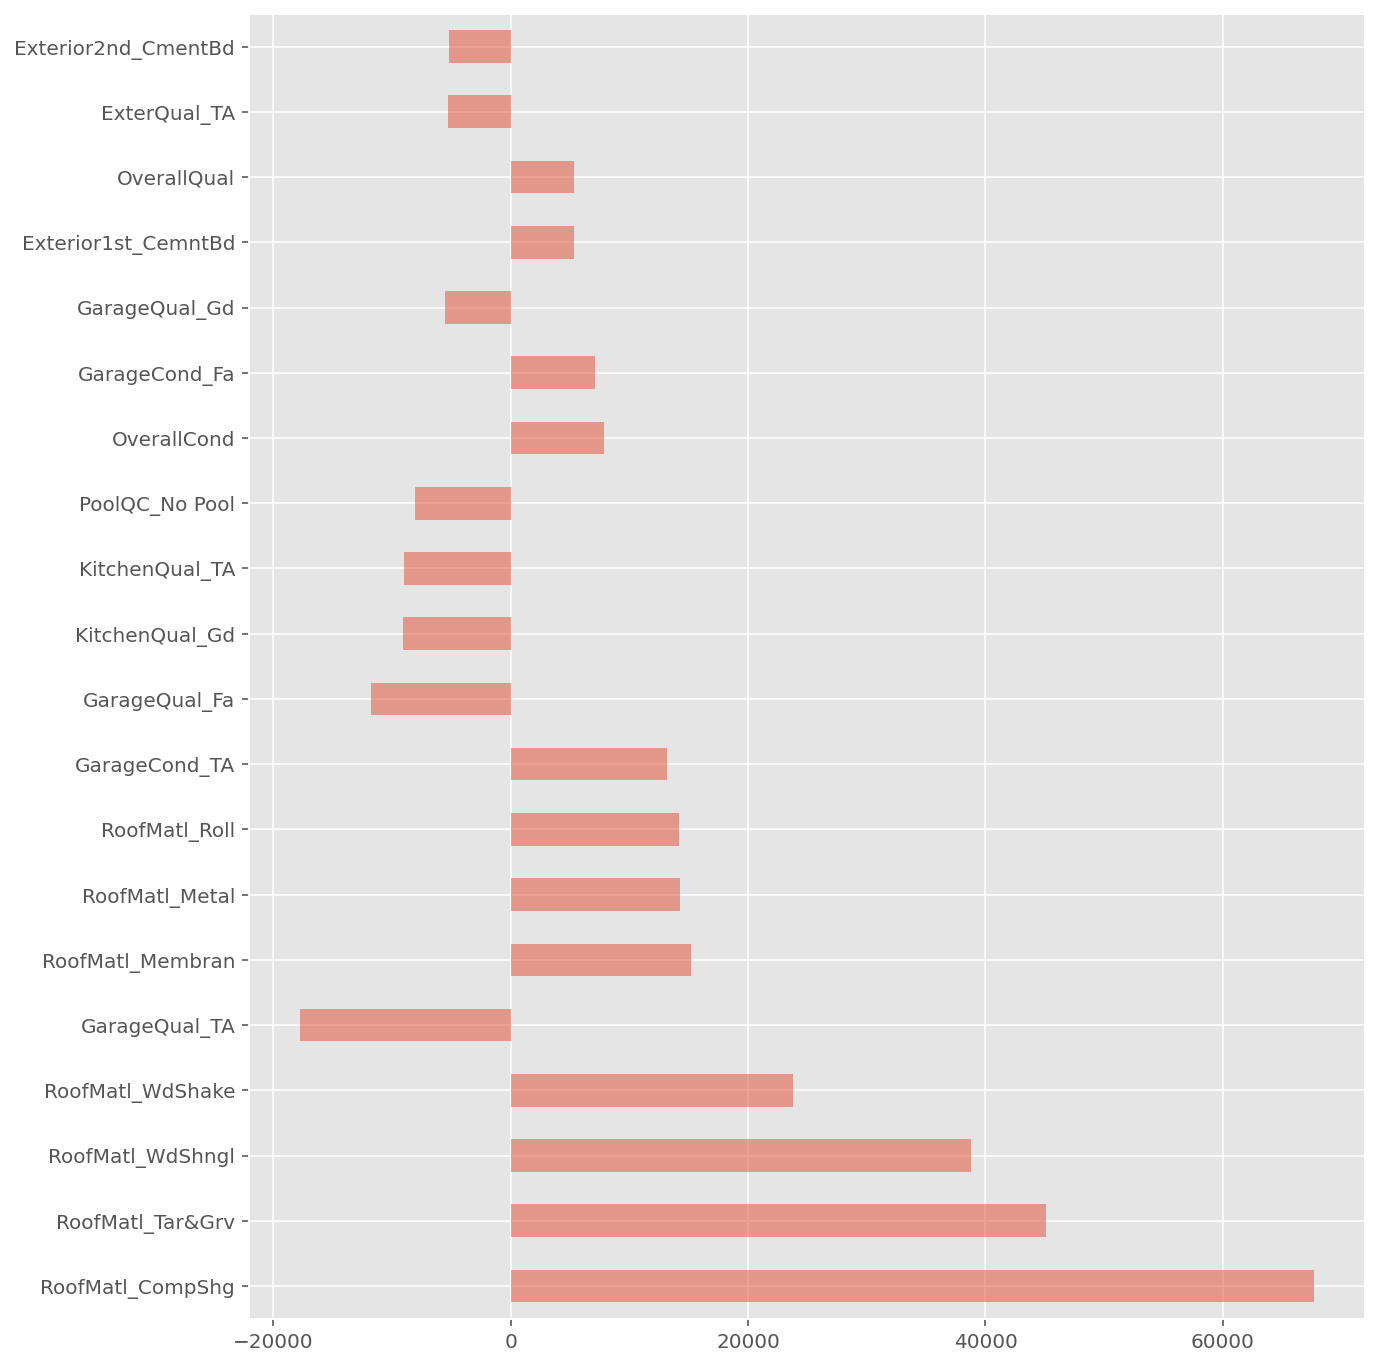

In [118]:
# Coefs 2 Plotted out:

fig, ax = plt.subplots(figsize=(10, 12))
model2L1_coefs.coef[:20].plot(kind='barh', ax=ax, alpha=0.5)
ax.set_yticklabels(model2L1_coefs.variable[:20].values)
plt.show()

### Notable Coefficients and Summary:

- It looks like the roof related features are the primary renovatable predictors in affecting housing prices. 
- These may be the first area of interest should one want to increase your property price, with the caveat being that you thoroughly look into the predictions from model 1 and have sufficient domain knowledge to review your hunches.
- Agsain consider the significantly weaker r^2 score in this model when deciding what constitutes the ideal renovatable features in increasing your house valuations.

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
Here we are interested in predicting the `Abnorml` category. 

---

This is a challenging task that tests your ability to perform classification analysis in the face of ***severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.***

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [119]:
# Use of Logitstic Regression and/or KNN

# Use full df & not those from Q1 & Q2, along with different train-test splits

# Add model tuning and evaluation techniques from W4 lessons e.g. GridSearch, confusion matrices, etc



In [120]:
# Checking the target variable & class imbalances (using the house_res residential df):
# 6 classes:
# Proportion of Adjland is too little


house_res['SaleCondition'].value_counts()

Normal     1155
Partial     103
Abnorml      92
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [121]:
# I'm going to drop 'AdjLand' from the df for this Q:
# The amount of 'AdjLand' is too small & will affect the train/test splits later:

house_res1 = house_res[house_res['SaleCondition'] != 'AdjLand']

In [122]:
house_res1['SaleCondition'].value_counts()

Normal     1155
Partial     103
Abnorml      92
Family       20
Alloca       11
Name: SaleCondition, dtype: int64

In [123]:
# This however only predicts the majority class:
# We want the 'Abnorml' class instead:

baseline = house_res1['SaleCondition'].value_counts(normalize=True)[0]
baseline

0.836350470673425

In [124]:
# This is the 'baseline' for this Q:

abnormal = house_res1['SaleCondition'].value_counts(normalize=True)[2]
abnormal

0.0666183924692252

#### Note: In unbalanced classification problems, it can be a good idea to use the optional argument class_weight='balanced' in logistic regression

-  I may start with a standard unweighted model just to check:
- Use stratify=y in the train-test split function to preserve the same class proportions.

In [125]:
# I'll have to re do dummified X for Q3 - as i'm dropping the 4 'AdjLand' observations:

house_res1.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1381.000000,1381.000000,1381,1381.000000,1381.000000,1381,1381,1381,1381,1381,...,1381.000000,1381,1381,1381,1381.000000,1381.000000,1381,1381,1381,1381.000000
unique,NaN,NaN,3,NaN,NaN,2,3,4,4,2,...,NaN,4,5,5,NaN,NaN,5,9,5,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,No Alley,Reg,Lvl,AllPub,...,NaN,No Pool,No Fence,No Misc Features,NaN,NaN,2009,WD,Normal,NaN
freq,NaN,NaN,1147,NaN,NaN,1377,1316,861,1236,1380,...,NaN,1374,1104,1329,NaN,NaN,321,1216,1155,NaN
mean,733.323678,55.286025,NaN,57.410572,10713.989862,NaN,NaN,NaN,NaN,NaN,...,2.916727,NaN,NaN,NaN,20.152064,6.314265,NaN,NaN,NaN,180356.446054
std,422.507589,40.920673,NaN,33.351751,10199.228820,NaN,NaN,NaN,NaN,NaN,...,41.305730,NaN,NaN,NaN,106.753366,2.696698,NaN,NaN,NaN,79907.783046
min,1.000000,20.000000,NaN,0.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,37900.000000
25%,365.000000,20.000000,NaN,43.000000,7711.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,NaN,NaN,NaN,129500.000000
50%,735.000000,50.000000,NaN,63.000000,9600.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,NaN,NaN,NaN,160000.000000
75%,1102.000000,70.000000,NaN,79.000000,11764.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,NaN,NaN,NaN,213000.000000


In [126]:
Pre_X3 = house_res1.copy()
Pre_X3.drop(columns='SaleCondition', axis=1, inplace=True)

In [127]:
Pre_X3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,1,60,RL,65.0,8450,Pave,No Alley,Reg,Lvl,AllPub,...,0,0,No Pool,No Fence,No Misc Features,0,2,2008,WD,208500
1,2,20,RL,80.0,9600,Pave,No Alley,Reg,Lvl,AllPub,...,0,0,No Pool,No Fence,No Misc Features,0,5,2007,WD,181500
2,3,60,RL,68.0,11250,Pave,No Alley,IR1,Lvl,AllPub,...,0,0,No Pool,No Fence,No Misc Features,0,9,2008,WD,223500
3,4,70,RL,60.0,9550,Pave,No Alley,IR1,Lvl,AllPub,...,0,0,No Pool,No Fence,No Misc Features,0,2,2006,WD,140000
4,5,60,RL,84.0,14260,Pave,No Alley,IR1,Lvl,AllPub,...,0,0,No Pool,No Fence,No Misc Features,0,12,2008,WD,250000


In [128]:
Pre_X3.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,...,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000
mean,733.323678,55.286025,57.410572,10713.989862,6.066618,5.610427,1970.120927,1984.165098,100.777002,451.061550,...,469.136133,96.868936,43.883418,22.612600,3.604634,15.707458,2.916727,20.152064,6.314265,180356.446054
std,422.507589,40.920673,33.351751,10199.228820,1.373631,1.124951,29.816356,20.544550,165.562921,459.368206,...,212.865965,127.071540,63.579280,62.145643,30.133136,56.959901,41.305730,106.753366,2.696698,79907.783046
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37900.000000
25%,365.000000,20.000000,43.000000,7711.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,315.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129500.000000
50%,735.000000,50.000000,63.000000,9600.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,387.000000,...,473.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,160000.000000
75%,1102.000000,70.000000,79.000000,11764.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,719.000000,...,576.000000,170.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,213000.000000
max,1460.000000,190.000000,141.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,791.920000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,700.000000,12.000000,755000.000000


In [129]:
# adding all categorical columns from Q1 & Q2

categorical3 = categorical + categorical2

In [130]:
categorical3

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'BsmtQual',
 'BsmtExposure',
 'GarageType',
 'GarageYrBlt',
 'PavedDrive',
 'MiscFeature',
 'SaleType',
 'Utilities',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence']

In [131]:
# Dummify, check if numerical cols included
# looks like I didn't need to do the categorical3 above - use it to cross-check instead


categorical_cols3 = Pre_X3.loc[:, Pre_X3.dtypes == np.object]
categorical3 = list(categorical_cols3.columns)

Pre_X3_cat = pd.get_dummies(Pre_X3, columns=categorical3, drop_first=True)
Pre_X3_cat.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,0,0,0,0,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,0,0,0,0,1


In [132]:
Pre_X3_cat.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
count,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,...,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000,1381.000000
mean,733.323678,55.286025,57.410572,10713.989862,6.066618,5.610427,1970.120927,1984.165098,100.777002,451.061550,...,0.232440,0.118755,0.002172,0.000724,0.005069,0.003621,0.003621,0.072411,0.002172,0.880521
std,422.507589,40.920673,33.351751,10199.228820,1.373631,1.124951,29.816356,20.544550,165.562921,459.368206,...,0.422541,0.323617,0.046575,0.026909,0.071040,0.060084,0.060084,0.259262,0.046575,0.324468
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.000000,20.000000,43.000000,7711.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,735.000000,50.000000,63.000000,9600.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,387.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1102.000000,70.000000,79.000000,11764.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,719.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1460.000000,190.000000,141.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,791.920000,5644.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
X3 = Pre_X3_cat
y3 = house_res1['SaleCondition']

In [134]:
X3.count()

Id                1381
MSSubClass        1381
LotFrontage       1381
LotArea           1381
OverallQual       1381
                  ... 
SaleType_ConLI    1381
SaleType_ConLw    1381
SaleType_New      1381
SaleType_Oth      1381
SaleType_WD       1381
Length: 352, dtype: int64

In [135]:
y3.count()

1381

### Data cleaning & preprocessing

- I'm going to be doing a more conventional train-test split here, as it was unspecified, not like in Q1 & Q2:

In [136]:
# Train test split:

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify=y3, test_size=0.2, random_state=1)

In [137]:
# Check shape

X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((1104, 352), (277, 352), (1104,), (277,))

In [138]:
# Scaling all predictors with StandardScaler:

scaler = StandardScaler() # Standardizing the default feature scaling method

X3_train = pd.DataFrame(scaler.fit_transform(X3_train),
                       columns=X3.columns)

X3_test = pd.DataFrame(scaler.transform(X3_test), 
                      columns=X3.columns)

In [139]:
# Check that it's scaled:

X3_train.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-0.130961,-0.868161,0.684464,0.122824,1.405715,-0.547456,1.265453,1.146089,2.142810,-0.959135,...,1.801709,-0.368514,-0.0522,-0.03011,-0.073922,-0.060302,-0.060302,3.602039,-0.042601,-2.679138
1,-0.548003,-0.868161,0.383301,-0.146509,-0.779047,1.232783,-0.161541,-0.934012,-0.603866,0.525831,...,-0.555029,-0.368514,-0.0522,-0.03011,-0.073922,-0.060302,-0.060302,-0.277621,-0.042601,0.373254


### Fitting a standard Logistic Regression model:

- penalty = 'none' and multiclass = 'multinomial' and 'ovr'

#### Note: In unbalanced classification problems, it can be a good idea to use the optional argument class_weight='balanced' in logistic regression

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

In [141]:
# Tweaked model_fitter function:

def model_fitter2(model, X_train, y_train, X_test, y_test, cv=5): # 5-fold cv the default, followed by 10
    
    model.fit(X_train, y_train)
    
    # Add SKFold
    
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    
    cv_score = cross_val_score(model, X_train, y_train, cv=skf)
    cv_score_m = np.mean(cv_score)
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return cv_score, cv_score_m, training_score, test_score # outputs in this order

### Standard multinomial model, weighted classes:

In [142]:
# Standard model, multinomial, weighted classes

model3_mlt = LogisticRegression(penalty='none', multi_class='multinomial', class_weight='balanced', max_iter=10000)

In [143]:
# Standard model fitter:

model_fitter2(model3_mlt, X3_train, y3_train, X3_test, y3_test)

(array([0.8115942 , 0.82246377, 0.80797101, 0.79710145]),
 0.8097826086956521,
 1.0,
 0.8194945848375451)

In [144]:
# predictions mlt

pred_mlt = model3_mlt.predict(X3_test)
print("Predictions:\n", pred_mlt[:10])

Predictions:
 ['Abnorml' 'Normal' 'Abnorml' 'Partial' 'Normal' 'Normal' 'Normal'
 'Normal' 'Family' 'Normal']


In [145]:
# Compared to actual:

print("Actual:\n", y3_test[:10].values)

Actual:
 ['Normal' 'Normal' 'Normal' 'Partial' 'Abnorml' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal']


In [146]:
# Viewing the value counts:

pd.DataFrame(pred_mlt).value_counts()

Normal     219
Abnorml     27
Partial     22
Family       8
Alloca       1
dtype: int64

In [147]:
pd.DataFrame(y3_test).value_counts()

SaleCondition
Normal           232
Partial           21
Abnorml           18
Family             4
Alloca             2
dtype: int64

### Standard ovr model, also weighted classes:

In [148]:
# Standard model, ovr, weighted classes

model3_ovr = LogisticRegression(penalty='none', multi_class='ovr', class_weight='balanced', max_iter=10000)

In [149]:
# Standard model fitter 2:

model_fitter2(model3_ovr, X3_train, y3_train, X3_test, y3_test)

(array([0.82608696, 0.83695652, 0.84057971, 0.8115942 ]),
 0.8288043478260869,
 1.0,
 0.8122743682310469)

In [150]:
# predictions ovr

pred_ovr = model3_ovr.predict(X3_test)
print("Predictions:\n", pred_ovr[:10])

Predictions:
 ['Normal' 'Normal' 'Partial' 'Partial' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal']


In [151]:
# Compared to actual again:

print("Actual:\n", y3_test[:10].values)

Actual:
 ['Normal' 'Normal' 'Normal' 'Partial' 'Abnorml' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal']


#### The below one way to visualize accuracy:

In [152]:
# Viewing the value counts:

pd.DataFrame(pred_ovr).value_counts()

Normal     222
Partial     27
Abnorml     14
Family       7
Alloca       7
dtype: int64

In [153]:
# Comparing with mlt again:

pd.DataFrame(pred_mlt).value_counts()

Normal     219
Abnorml     27
Partial     22
Family       8
Alloca       1
dtype: int64

In [154]:
# Comparing to Actual

pd.DataFrame(y3_test).value_counts()

SaleCondition
Normal           232
Partial           21
Abnorml           18
Family             4
Alloca             2
dtype: int64

### Confusion matrices, accuracies and classification reports on the standard test sets:

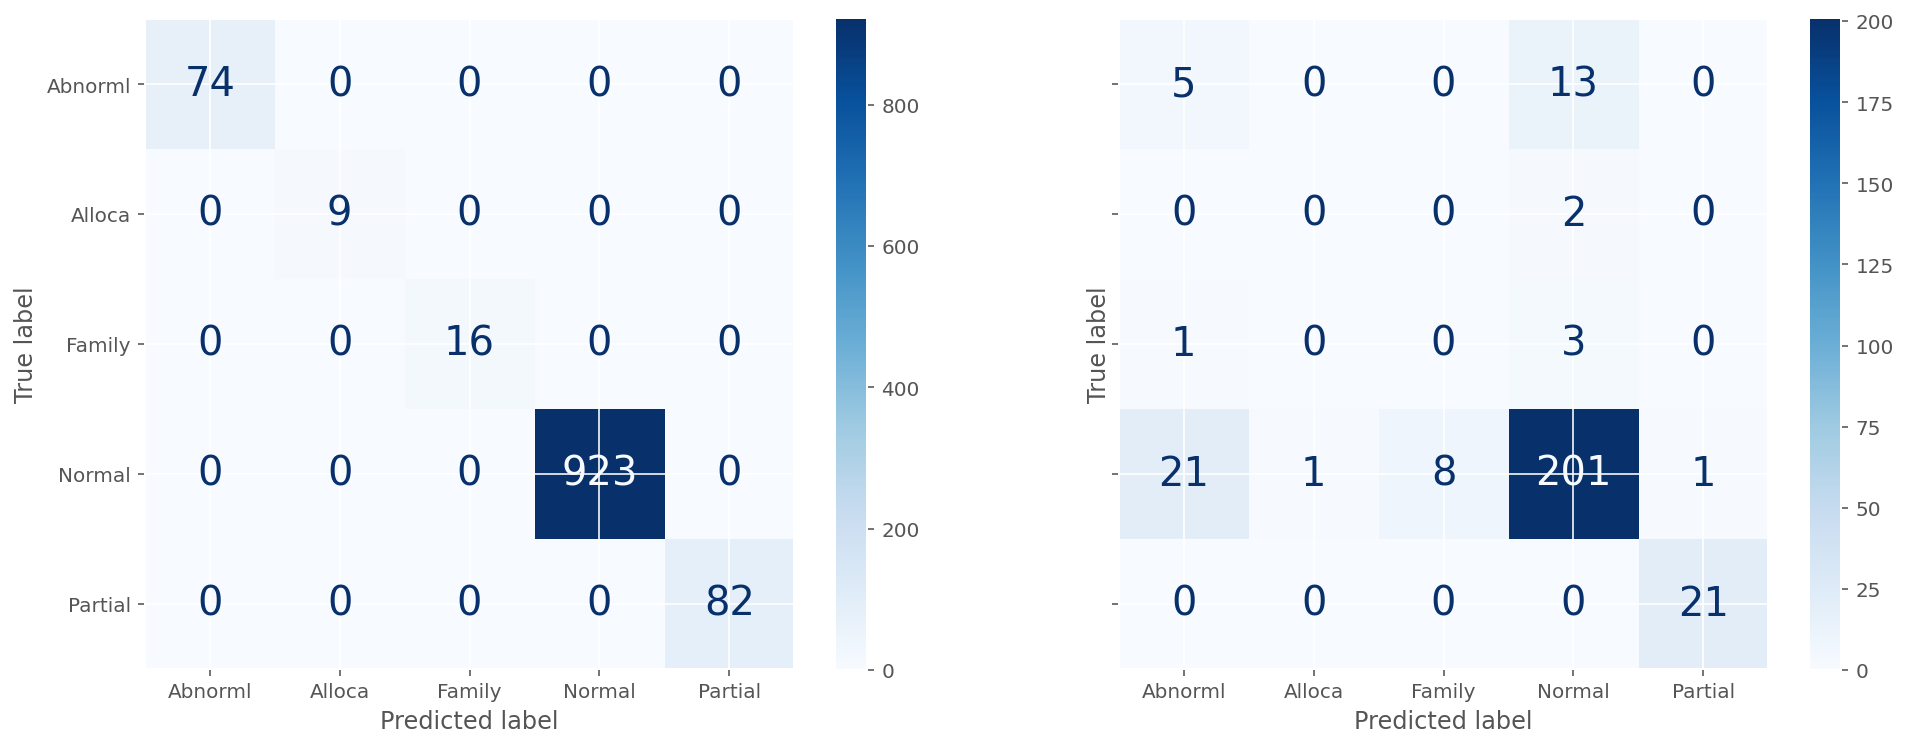

In [155]:
# Confusion Matrix, standard mlt model (train left, test right):

# Read false positives through columns (vertically)
# Read false negatives through rows (horizontally)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

plot_confusion_matrix(model3_mlt, X3_train, y3_train, cmap='Blues', ax=ax[0])
plot_confusion_matrix(model3_mlt, X3_test, y3_test, cmap='Blues', ax=ax[1])

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

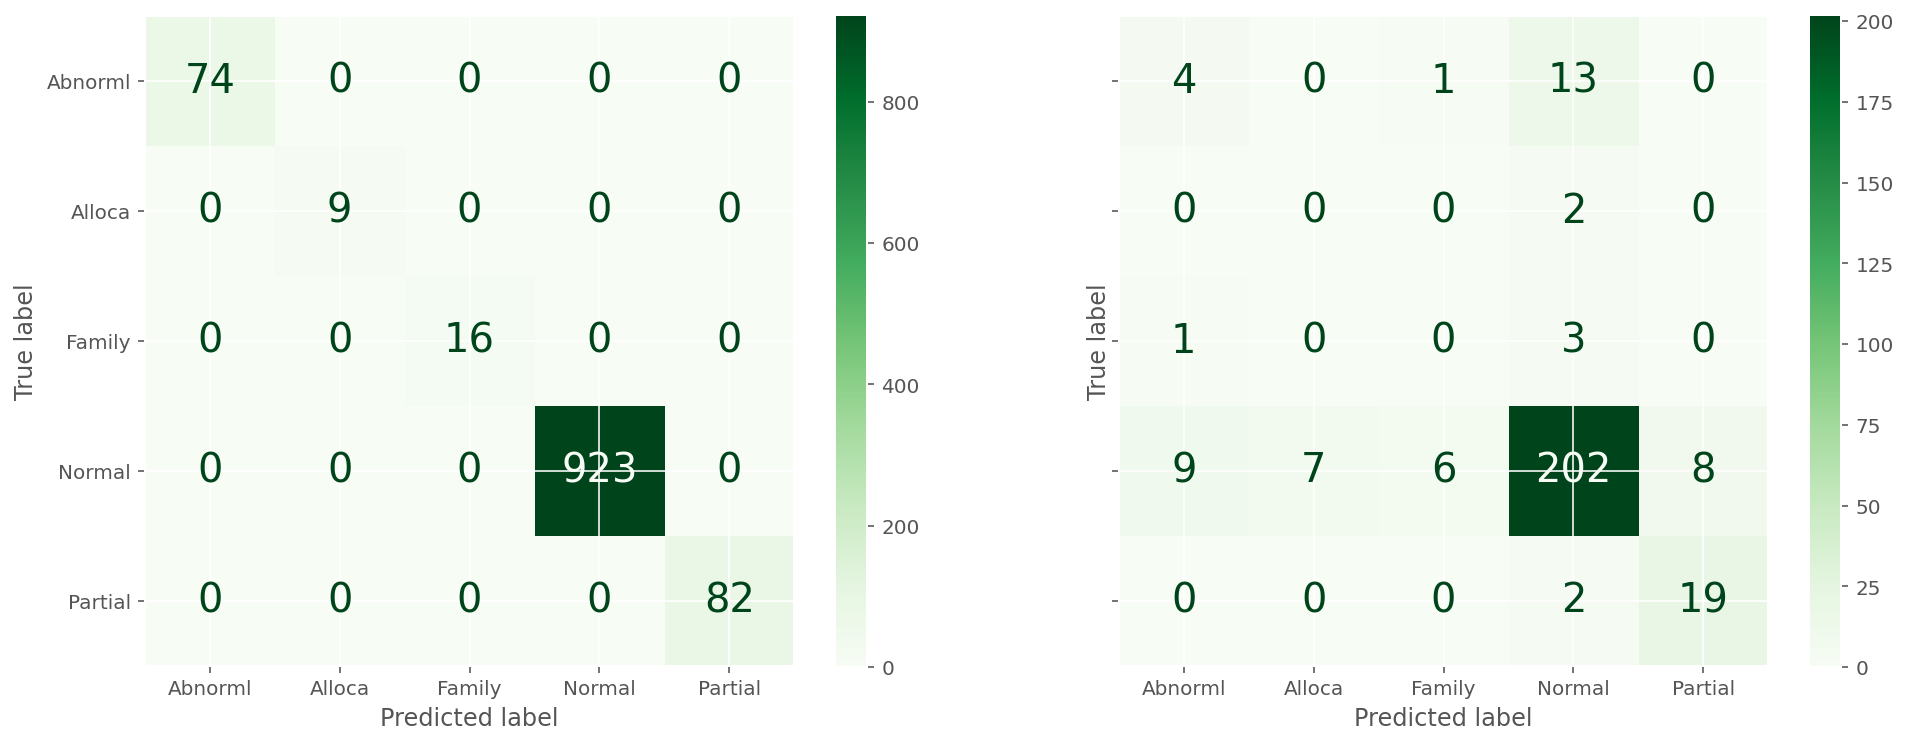

In [156]:
# Confusion matrix of ovr model (train left, test right):

fig, ax = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

plot_confusion_matrix(model3_ovr, X3_train, y3_train, cmap='Greens', ax=ax[0])
plot_confusion_matrix(model3_ovr, X3_test, y3_test, cmap='Greens', ax=ax[1])

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

#### Classification reports for test sets:

In [157]:
# mlt:

print(classification_report(y3_test, pred_mlt))

              precision    recall  f1-score   support

     Abnorml       0.19      0.28      0.22        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.92      0.87      0.89       232
     Partial       0.95      1.00      0.98        21

    accuracy                           0.82       277
   macro avg       0.41      0.43      0.42       277
weighted avg       0.85      0.82      0.84       277



In [158]:
# ovr:

print(classification_report(y3_test, pred_ovr))

              precision    recall  f1-score   support

     Abnorml       0.29      0.22      0.25        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.91      0.87      0.89       232
     Partial       0.70      0.90      0.79        21

    accuracy                           0.81       277
   macro avg       0.38      0.40      0.39       277
weighted avg       0.83      0.81      0.82       277



### Implementing a default knn model to compare:

In [159]:
from sklearn.neighbors import KNeighborsClassifier

In [160]:
# Using the default settings:

model3_knn = KNeighborsClassifier(n_neighbors=5)

In [161]:
model3_knn.fit(X3_train, y3_train)

KNeighborsClassifier()

In [162]:
# standard model:

model_fitter2(model3_knn, X3_train, y3_train, X3_test, y3_test)

(array([0.89130435, 0.86956522, 0.89130435, 0.88768116]),
 0.8849637681159419,
 0.8994565217391305,
 0.8592057761732852)

In [163]:
# knn predictions

pred_knn = model3_knn.predict(X3_test)
print("Predictions:\n", pred_knn[:10])

Predictions:
 ['Normal' 'Normal' 'Partial' 'Partial' 'Normal' 'Normal' 'Normal' 'Normal'
 'Alloca' 'Normal']


In [164]:
# Looks like this is already a significantly worse model
# Will skip over this and focus on logit models

pd.DataFrame(pred_knn).value_counts()

Normal     251
Partial     20
Alloca       3
Abnorml      2
Family       1
dtype: int64

In [165]:
pd.DataFrame(y3_test).value_counts()

SaleCondition
Normal           232
Partial           21
Abnorml           18
Family             4
Alloca             2
dtype: int64

### Comment:

- Looks like I could go with the default logit ovr model for 'Abnorml' classes?
- A 0.29 precision score, 0.22 recall score & 0.25 f1 score looks ok.
- How would the imbalanced dataset affect this? Did having class_weights = balanced help?
- Will need to do more model tuning.

### Using Gridsearch to find optimal model:
- Will only be doing this for the logit models (notebook is getting too long):

In [166]:
from sklearn.model_selection import GridSearchCV

- You always want to use your training data to search for your best hyperparameters! You can do this with GridSearchCV, or with other sklearn objects like RidgeCV, LassoCV, ElasticNetCV, or LogisticRegressionCV.  


- You instantiate GridSearchCV with:
    - a model
    - a dictionary for that model's parameters
    - the number of cross-validation folds you want it to perform (`cv=5`)
    - how many cores to use on your computer for this job (`n_jobs=1`)
    - whether you want your model to give you some print-outs while it works (`verbose=1`)
    

- Once you've instantiated the GridSearch object, you can fit it on your training data


- Once it's finished searching, you can access some useful attributes:
    - `.best_score_`, to find the mean cross-validated score of the best estimator
    - `.best_params_`, to find the best hyperparameters 
    - refer to `.best_estimator_` to extract `.coef_`, etc
    - `.score()` and `.predict()` used on the gridsearched model will make use of the best estimator
    - `.cv_results_` to display results about all models (only available if you set `return_train_score=True`)

In [167]:
# Logit model and parameters:

logit = LogisticRegression(solver='liblinear', class_weight='balanced')
list(logit.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [168]:
# setup the grid search
# This takes too long to process - will need to rent a server or get a good gpu setup for future


# Using RepeatedStratifiedKFold to better capture variance

# rskf = RepeatedStratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# params = {'C': np.logspace(-5, 5, 20),
#           'penalty': ['l1', 'l2'],
#           'multi_class': ['multinomial', 'ovr'],
#           'fit_intercept': [True, False]}

# gs = GridSearchCV(estimator=logit,
#                   param_grid=params,
#                   cv=rskf,
#                   scoring='accuracy', # note: accuracy not helpful when you want to predict a minority class
#                   n_jobs=-2,
#                   verbose=1)

# gs.fit(X3_train, y3_train)

# # extract the grid search results

# print('Best Parameters:')
# print(gs.best_params_)
# print('Best estimator C:')
# print(gs.best_estimator_.C)
# print('Best estimator mean cross validated training score:')
# print(gs.best_score_)
# print('Best estimator score on the full training set:')
# print(gs.score(X3_train, y3_train))
# print('Best estimator score on the test set:')
# print(gs.score(X3_test, y3_test))
# print('Best estimator coefficients:')
# print(gs.best_estimator_.coef_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-2)]: Done 688 tasks      | elapsed: 21.0min


Best Parameters:
{'C': 0.004281332398719391, 'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l1'}
Best estimator C:
0.004281332398719391
Best estimator mean cross validated training score:
0.8940148087206911
Best estimator score on the full training set:
0.8940217391304348
Best estimator score on the test set:
0.8628158844765343
Best estimator coefficients:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.59774236 0.         0.        ]]


[Parallel(n_jobs=-2)]: Done 800 out of 800 | elapsed: 35.0min finished


#### Gridsearch best parameters:

- To avoid re-running the Gridsearch (takes approximately 35-45 mins):

{'C': 0.004281332398719391, 'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l1'}


#### Gridsearch other scores:

- Best estimator C:
0.004281332398719391
- Best estimator mean cross validated training score:
0.8940148087206911
- Best estimator score on the full training set:
0.8940217391304348
- Best estimator score on the test set:
0.8628158844765343

- No best estimator coefficients of note

#### Comment:

- The above not too interpretable
- Will need model scores below
- We can also see the confusion matrix for the GS logit model instead:

In [169]:
# Assigning the best fit model (best_estimator_)

gs.best_estimator_

LogisticRegression(C=0.004281332398719391, class_weight='balanced',
                   multi_class='ovr', penalty='l1', solver='liblinear')

In [170]:
# best scores (accuracy):

best_logit = gs.best_estimator_

print(best_logit.score(X3_train, y3_train))
print(best_logit.score(X3_test, y3_test))

0.8940217391304348
0.8628158844765343


### Confusion Matrix for the GS logit model:

In [172]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(gs.classes_)))

In [173]:
gspred_train = gs.predict(X3_train)
gspred_test = gs.predict(X3_test)

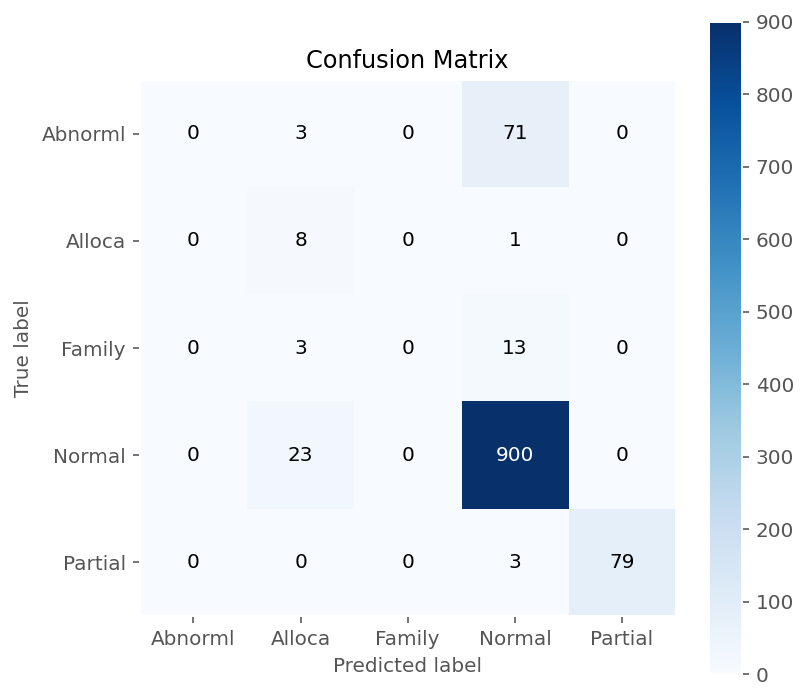

In [174]:
# Not looking too promising unfortunately

skplt.metrics.plot_confusion_matrix(y3_train, gspred_train, figsize=(6,6))
plt.show()

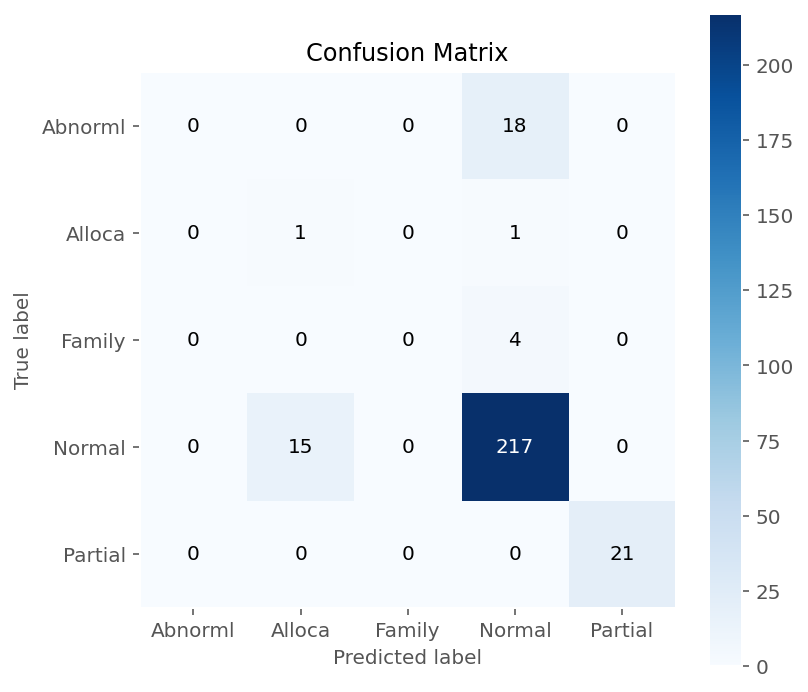

In [175]:
skplt.metrics.plot_confusion_matrix(y3_test, gspred_test, figsize=(6,6))
plt.show()

### Classification Reports

In [176]:
print(classification_report(y3_train, gspred_train, digits=5))

              precision    recall  f1-score   support

     Abnorml    0.00000   0.00000   0.00000        74
      Alloca    0.21622   0.88889   0.34783         9
      Family    0.00000   0.00000   0.00000        16
      Normal    0.91093   0.97508   0.94192       923
     Partial    1.00000   0.96341   0.98137        82

    accuracy                        0.89402      1104
   macro avg    0.42543   0.56548   0.45422      1104
weighted avg    0.83762   0.89402   0.86322      1104



/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
print(classification_report(y3_test, gspred_test, digits=5))

              precision    recall  f1-score   support

     Abnorml    0.00000   0.00000   0.00000        18
      Alloca    0.06250   0.50000   0.11111         2
      Family    0.00000   0.00000   0.00000         4
      Normal    0.90417   0.93534   0.91949       232
     Partial    1.00000   1.00000   1.00000        21

    accuracy                        0.86282       277
   macro avg    0.39333   0.48707   0.40612       277
weighted avg    0.83354   0.86282   0.84673       277



### How to handle imbalance?

- Found a few resampling methods:
- Over/Undersampling is one method
- The method I'd be curious to try is **SMOTE (Synthetic Minority Oversampling Technique)** - generates new samples that are coherent with the minor class distribution.
- I'm only going to be using this one to avoid cluttering notebook (and as I'm more curious to try out some other alternate classifiers).

***Other resampling techniques that the class can hopefully go over***
- ADASYN Technique
- SMOTE + Tomek Links
- SMOTE + ENN

### Alternate classifier models:

- However, I'd first want to try out 3 other classifiers that hopefully are covered in the course in greater detail.
- RandomForestClassifier()
- GradientBoostingClassifier()
- AdaBoostClassifier()

**Other Classifier models that can hopefully be looked at too:**
- Decision Tree Classifier
- XGBoost - This seems quite popular for some reason.
- SVN
- HistGradientBoost
- LGBMClassifier
- And many more

In [178]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

#### SMOTE

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [179]:
sm = SMOTE(random_state=12)

# Resampled data:
X3_train_res, y3_train_res = sm.fit_resample(X3_train, y3_train)

print (y3_train.value_counts() ,'\n\nSMOTE:\n',y3_train_res.value_counts())

Normal     923
Partial     82
Abnorml     74
Family      16
Alloca       9
Name: SaleCondition, dtype: int64 

SMOTE:
 Normal     923
Family     923
Alloca     923
Partial    923
Abnorml    923
Name: SaleCondition, dtype: int64


In [180]:
# Random Forest
# Still IndefinedMetricWarning Here
# No scores, still not helpful

modelRF = RandomForestClassifier(n_estimators=1000)
modelRF.fit(X3_train_res, y3_train_res)

y3_predRF = modelRF.predict(X3_test)
target_names = ['Abnorml', 'Alloca', 'Family', 'Normal', 'Partial']
print(classification_report(y3_test, y3_predRF, target_names=target_names))

              precision    recall  f1-score   support

     Abnorml       0.00      0.00      0.00        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.91      0.99      0.95       232
     Partial       1.00      1.00      1.00        21

    accuracy                           0.91       277
   macro avg       0.38      0.40      0.39       277
weighted avg       0.83      0.91      0.87       277



/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
# Gradient Boost (takes some time to model ~5 mins)
# Most balanced scores of the three for 'Abnorml'

modelGB = GradientBoostingClassifier(n_estimators=1000)
modelGB.fit(X3_train_res, y3_train_res)

y3_predGB = modelGB.predict(X3_test)
target_names = ['Abnorml', 'Alloca', 'Family', 'Normal', 'Partial']
print(classification_report(y3_test, y3_predGB, target_names=target_names))

              precision    recall  f1-score   support

     Abnorml       0.27      0.17      0.21        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.91      0.95      0.93       232
     Partial       1.00      1.00      1.00        21

    accuracy                           0.88       277
   macro avg       0.44      0.42      0.43       277
weighted avg       0.86      0.88      0.87       277



In [182]:
# Ada Boost
# Highest recall score here

modelAB = AdaBoostClassifier(n_estimators=1000)
modelAB.fit(X3_train_res, y3_train_res)

y3_predAB = modelAB.predict(X3_test)
target_names = ['Abnorml', 'Alloca', 'Family', 'Normal', 'Partial']
print(classification_report(y3_test, y3_predAB, target_names=target_names))

              precision    recall  f1-score   support

     Abnorml       0.07      0.39      0.12        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.91      0.46      0.61       232
     Partial       1.00      1.00      1.00        21

    accuracy                           0.48       277
   macro avg       0.40      0.37      0.35       277
weighted avg       0.84      0.48      0.59       277



/Users/marzimin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Also adding back LogisticRegression to compare:

In [199]:
# Resampled Logit model:
# Also using outputs from GridSearch:


model3_LR = LogisticRegression(C= 0.004281332398719391, multi_class = 'ovr',
 penalty= 'l1', solver='liblinear', class_weight='balanced') # would I still need to specify class_weight?

model3_LR.fit(X3_train_res, y3_train_res)

y3_predLR = model3_LR.predict(X3_test)
target_names = ['Abnorml', 'Alloca', 'Family', 'Normal', 'Partial']
print(classification_report(y3_test, y3_predLR, target_names=target_names))

              precision    recall  f1-score   support

     Abnorml       0.12      0.22      0.16        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.90      0.67      0.77       232
     Partial       1.00      1.00      1.00        21

    accuracy                           0.65       277
   macro avg       0.40      0.38      0.39       277
weighted avg       0.84      0.65      0.73       277



### Creating a ROC & Precision-Recall Curve for the best resampled model:

- Will be going with **the resampled logit model** as other classifiers don't have a coef function that I know of:

In [200]:
probabilities_train = model3_LR.predict_proba(X3_train)
probabilities_test = model3_LR.predict_proba(X3_test)

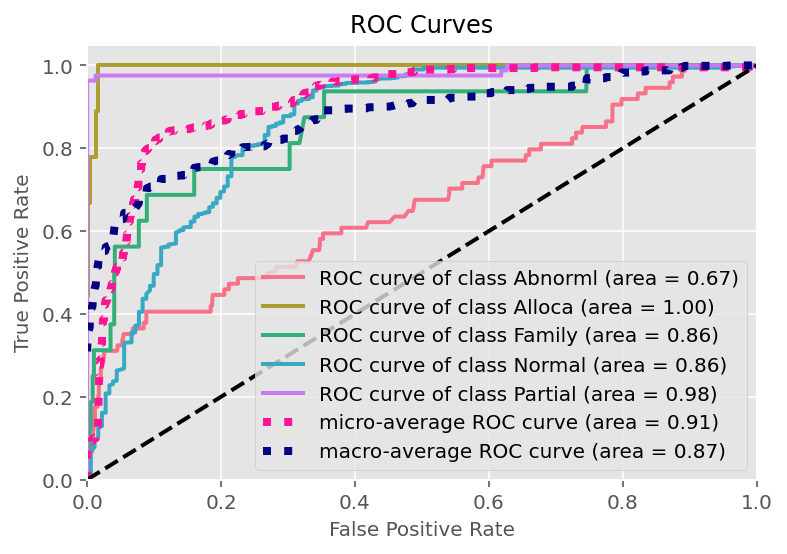

In [201]:
# ROC Curve (train)

# Note, class imbalnce can cause ROC curves to be poor visualizations of classifier performance.

skplt.metrics.plot_roc(y3_train, probabilities_train, cmap=cmap)
plt.show()

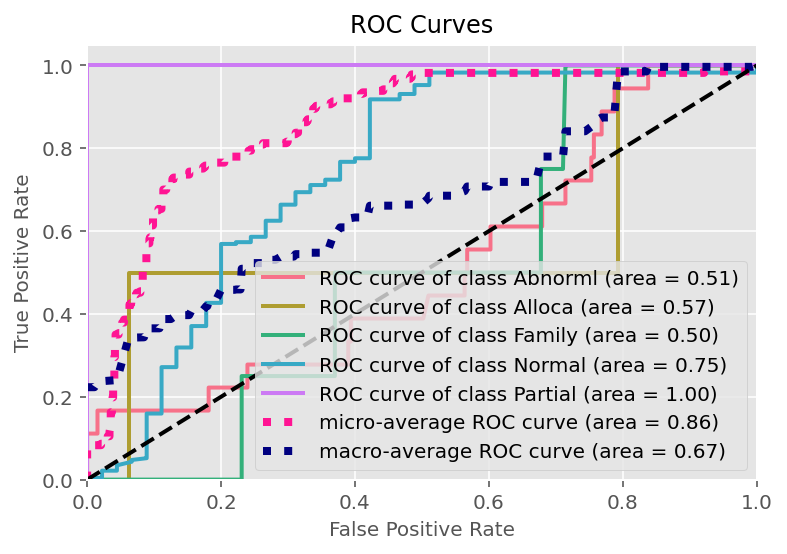

In [202]:
# ROC Curve (test)
# Anything of note?

skplt.metrics.plot_roc(y3_test, probabilities_test, cmap=cmap)
plt.show()

In [203]:
# PR Curve with f1-score level lines:

def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

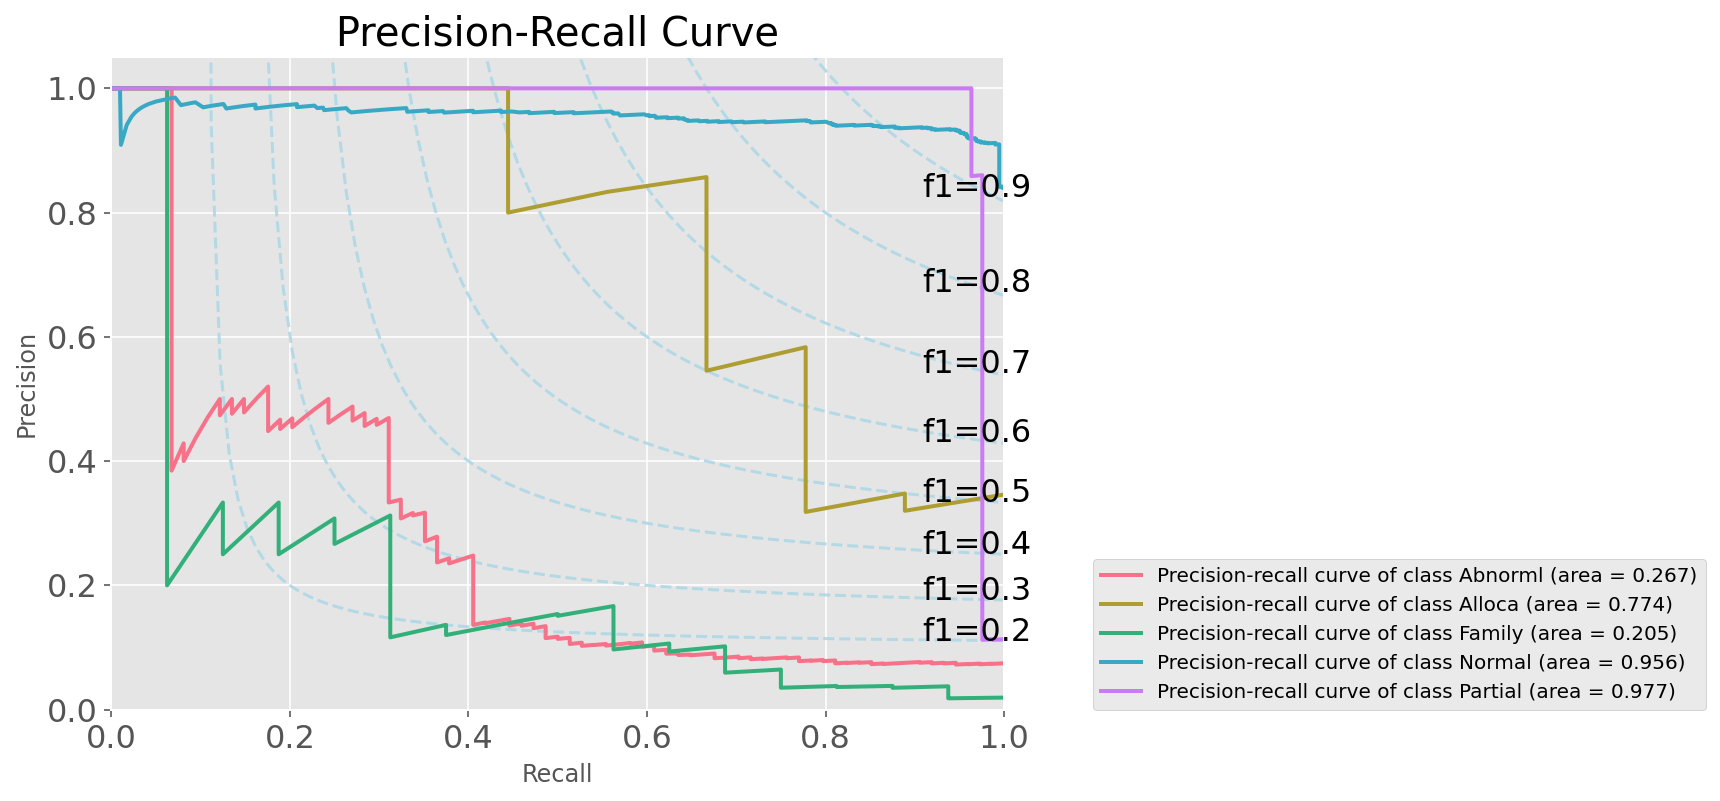

In [204]:
# Some nicer looking PR Curves:
# Train

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y3_train, probabilities_train,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

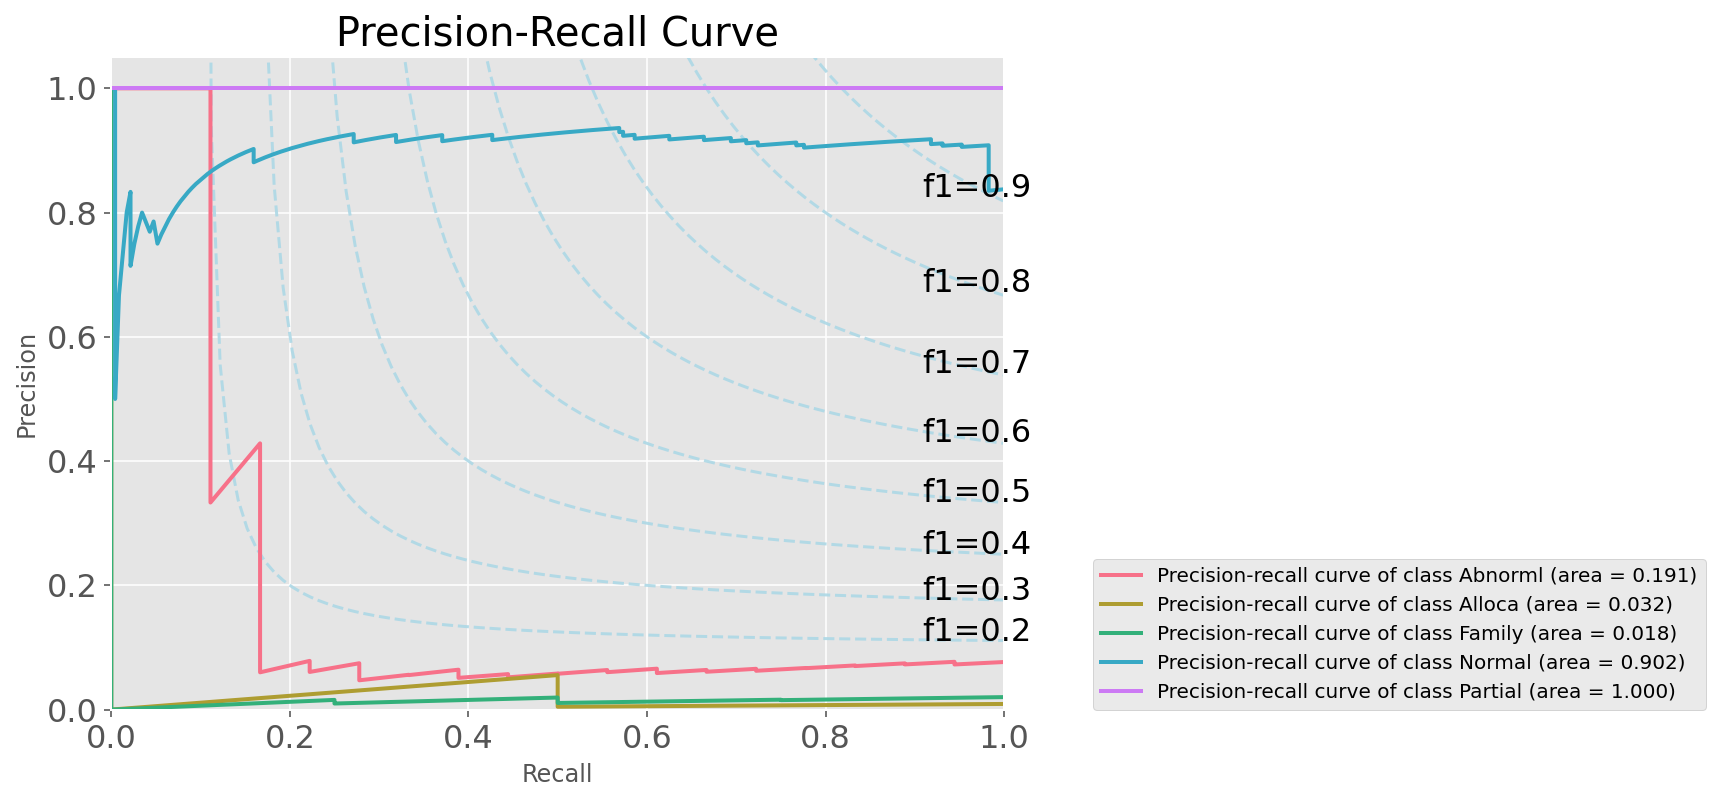

In [205]:
# Test
# Make inferences from this alone I suppose:

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y3_test, probabilities_test,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

#### Conclusions:

**For the test sets:**

- Roc Curve where Abnorml = 0.51
- Precision Curve where Abnorml = 0.191


**Generally Precision-Recall curves are recommended over ROC for imbalanced data. ROC curves can overestimate the performance of classifier on imbalanced data whereas PR curves reveal the drop in precision at the same level of recall for the imbalanced data.**


- Remember that Precision measures how many times the true label was positive out of all the times the classifier predicted a positive label.

- Also remember that Recall measures how many times the predicted label was positive out of all the times the true label was positive.

- Hence, if you are fine with a lower recall score (0.1-0.2), you can get a respectable to great precision score for the 'Abnorml' class. 
- If low recall in this case measures the false negatives for 'Abnorml' houses (i.e. actual abnormal sales that are classed as normal), then it is something worth looking further into.
- Conversely you would want a higher precision score too as you don't want 'Normal' & other properties to be wrongly classed as 'Abnorml'.

- However, this model is still not as strong as I would have liked due to their low scores, and thus wouln't be able to solely rely on it for classifying 'Abnorml' properties as well as its target coefficients.
- **Would the standard 'ovr' model above with non-resampled data be better? It's precision, recall & f1 scores are interpretable and even higher for 'Abnorml'.**
- I'd also imagine some of the other untested classifier models may yield higher scores,  with better tuning methods too. Would need a way to retrieve the best coefficients from them though. 

### Identifying the best coefficients for model 3:

In [206]:
# Resampled Logit model report:

print(classification_report(y3_test, y3_predLR, target_names=target_names))

              precision    recall  f1-score   support

     Abnorml       0.12      0.22      0.16        18
      Alloca       0.00      0.00      0.00         2
      Family       0.00      0.00      0.00         4
      Normal       0.90      0.67      0.77       232
     Partial       1.00      1.00      1.00        21

    accuracy                           0.65       277
   macro avg       0.40      0.38      0.39       277
weighted avg       0.84      0.65      0.73       277



In [207]:
# Class order - handy to identify per class coefs:

model3_LR.classes_

array(['Abnorml', 'Alloca', 'Family', 'Normal', 'Partial'], dtype=object)

In [208]:
# First item [0] will be for 'Abnorml', [1] = 'Alloca', and so on.
model3_LR.coef_

array([[ 0.        ,  0.        ,  0.        , ..., -0.58223333,
         0.06450307, -0.11402279],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.32900689],
       [ 0.        ,  0.        ,  0.        , ..., -0.23194952,
         0.        ,  0.52931872],
       [ 0.        ,  0.        ,  0.        , ...,  1.38378529,
         0.        ,  0.        ]])

In [209]:
# create a dataframe to look at the coefficients

coef_df = pd.DataFrame({'feature': X3.columns,
                        'coef': model3_LR.coef_[0], # For 'Abnorml'
                        'abs_coef': np.abs(model3_LR.coef_[0])})



In [210]:
# sort by absolute value of coefficient (magnitude)

coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.head(10)

,feature,coef,abs_coef
349,SaleType_New,-0.582233,0.582233
94,BldgType_Duplex,-0.387568,0.387568
341,YrSold_2008,0.164504,0.164504
124,Exterior1st_Plywood,-0.164264,0.164264
351,SaleType_WD,-0.114023,0.114023
126,Exterior1st_Stucco,-0.070791,0.070791
65,Neighborhood_NAmes,0.067454,0.067454
350,SaleType_Oth,0.064503,0.064503
256,GarageYrBlt_1954,-0.049661,0.049661
7,YearRemodAdd,-0.040150,0.040150


### Chosen Coefficients:

- So these are the coefficients worth looking further into when trying to identify features that contribute to 'Abnorml' sales.
- Aside from YrSold_2008, the rest are all negative, implying that:
- New properties and Duplexes and  aren't likely to be Abnormal
- Followed by Plywood Exteriors, Sale Type Warranty Deed - Conventional also having a significant inverse relationship with Abnormal sales.
- The highest positive correlation to Abnormal sales, that of houses being sold in 2008 is interesting, likely due to the financial crisis of the same year that dubious, inflated real estate sales have played a role in.
